Saving 308073_small.mp4 to 308073_small.mp4
Frames extraídos: 905
Tiempo total CPU: 21.16533064842224
Tiempo promedio: 0.023387105688864356
Frames por segundo procesados: 42.758604390971925


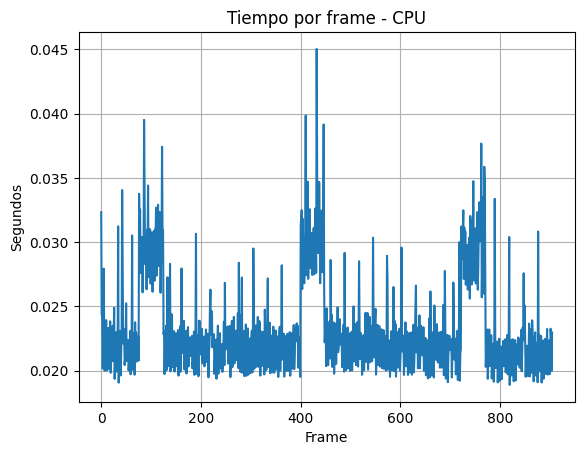

In [1]:
from google.colab import files
import cv2
import os
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import HTML

# Carpetas
FOLDER_VIDEO = "video"
FOLDER_FRAMES_ORIG = "frames_video_original"
FOLDER_FRAMES_RESULT = "frames_video_result"
VIDEO_RESULT_NAME = "video_result_cpu.mp4"
VIDEO_RESULT_FPS = 30.0

# Limpiar ambiente
for p in [FOLDER_VIDEO, FOLDER_FRAMES_ORIG, FOLDER_FRAMES_RESULT]:
    if os.path.exists(p):
        shutil.rmtree(p)
    os.makedirs(p, exist_ok=True)

# Subir video
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
src = video_filename
dst = os.path.join(FOLDER_VIDEO, video_filename)
shutil.move(src, dst)
video_path = dst

# Extraer frames
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

saved_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    filename = f"frame_{saved_count:09d}.jpg"
    cv2.imwrite(os.path.join(FOLDER_FRAMES_ORIG, filename), frame)
    saved_count += 1

cap.release()
print("Frames extraídos:", saved_count)

# Procesamiento CPU
times_cpu = []

for i in range(saved_count):
    filename = f"frame_{i:09d}.jpg"
    img_bgr = cv2.imread(os.path.join(FOLDER_FRAMES_ORIG, filename))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    start = time.time()
    gray = (0.2989 * img_rgb[:, :, 0] +
            0.5870 * img_rgb[:, :, 1] +
            0.1140 * img_rgb[:, :, 2]).astype(np.uint8)
    elapsed = time.time() - start
    times_cpu.append(elapsed)

    cv2.imwrite(os.path.join(FOLDER_FRAMES_RESULT, filename), gray)

# Reconstruir video
first = cv2.imread(os.path.join(FOLDER_FRAMES_RESULT, "frame_000000000.jpg"))
h, w = first.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter(VIDEO_RESULT_NAME, fourcc, VIDEO_RESULT_FPS, (w, h))

for i in range(saved_count):
    img = cv2.imread(os.path.join(FOLDER_FRAMES_RESULT, f"frame_{i:09d}.jpg"), cv2.IMREAD_GRAYSCALE)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    video_out.write(img_bgr)

video_out.release()

# Métricas
total = sum(times_cpu)
avg = np.mean(times_cpu)
fps_proc = 1 / avg

print("Tiempo total CPU:", total)
print("Tiempo promedio:", avg)
print("Frames por segundo procesados:", fps_proc)

plt.plot(times_cpu)
plt.title("Tiempo por frame - CPU")
plt.xlabel("Frame")
plt.ylabel("Segundos")
plt.grid(True)
plt.show()



In [1]:
!pip install cupy-cuda12x

Saving 308073_small.mp4 to 308073_small.mp4
Frames extraídos: 905
Video reconstruido: video_result_gpu_cupy.mp4
Tiempo total GPU (procesamiento frames): 4.011 s
Tiempo promedio por frame (GPU): 0.004432 s
Throughput aproximado GPU (frames/s): 225.63


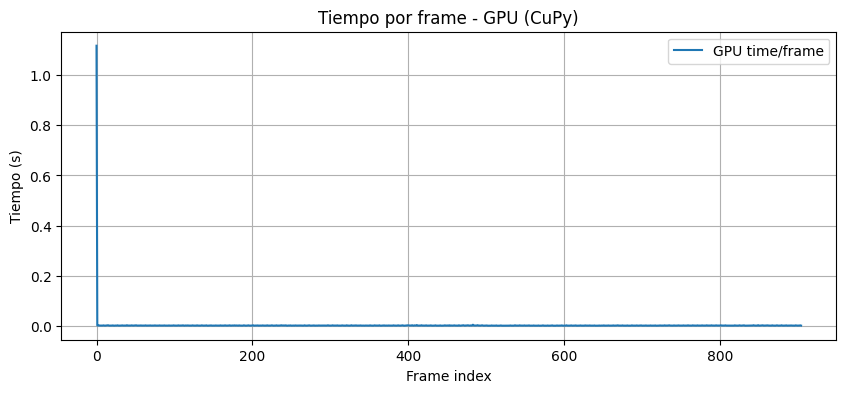

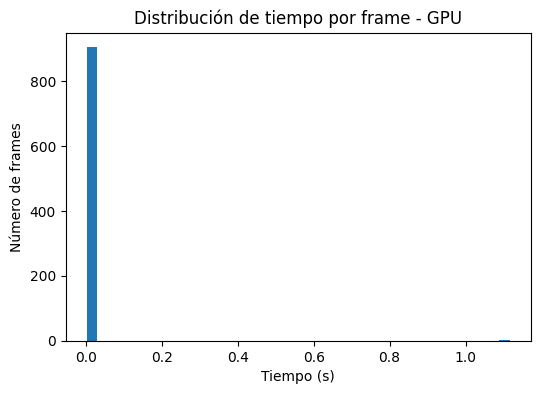

In [2]:
from google.colab import files
import cv2
import os
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import HTML, display

try:
    import cupy as cp
except Exception:
    print("Instalando cupy para CUDA 12 (esto puede tardar unos minutos)...")
    !pip install -q cupy-cuda12x
    import importlib
    importlib.invalidate_caches()
    import cupy as cp

# Rutas y parámetros
FOLDER_VIDEO = "video"
FOLDER_FRAMES_ORIG = "frames_video_original"
FOLDER_FRAMES_RESULT = "frames_video_result"
VIDEO_RESULT_NAME = "video_result_gpu_cupy.mp4"
VIDEO_RESULT_FPS = 30.0

# Limpiar ambiente
for p in [FOLDER_VIDEO, FOLDER_FRAMES_ORIG, FOLDER_FRAMES_RESULT]:
    if os.path.exists(p):
        shutil.rmtree(p)
    os.makedirs(p, exist_ok=True)

# Subir video (obligatorio)
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
shutil.move(video_filename, os.path.join(FOLDER_VIDEO, video_filename))
video_path = os.path.join(FOLDER_VIDEO, video_filename)

# Extraer frames
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise SystemExit("No se pudo abrir el video.")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
saved_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    filename = f"frame_{saved_count:09d}.jpg"
    cv2.imwrite(os.path.join(FOLDER_FRAMES_ORIG, filename), frame)
    saved_count += 1
cap.release()
print("Frames extraídos:", saved_count)

if saved_count == 0:
    raise SystemExit("No hay frames extraídos.")

# Función de procesamiento por frame usando CuPy (enteros)
# Fórmula entera equivalente: gray = (77*R + 150*G + 29*B) >> 8
times_gpu = []

for i in range(saved_count):
    filename = f"frame_{i:09d}.jpg"
    path_in = os.path.join(FOLDER_FRAMES_ORIG, filename)
    bgr = cv2.imread(path_in)
    if bgr is None:
        print(f"Advertencia: no se pudo leer {filename}")
        continue

    # BGR -> RGB
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Transferir a GPU
    start = time.perf_counter()
    d = cp.asarray(rgb, dtype=cp.uint8)  # shape (h, w, 3)

    # Promover a uint16 para evitar overflow en multiplicaciones
    r = d[:, :, 0].astype(cp.uint16)
    g = d[:, :, 1].astype(cp.uint16)
    b = d[:, :, 2].astype(cp.uint16)

    gray16 = (77 * r + 150 * g + 29 * b) >> 8
    gray8 = gray16.astype(cp.uint8)

    # Copiar de vuelta al host
    host_gray = cp.asnumpy(gray8)
    elapsed = time.perf_counter() - start
    times_gpu.append(elapsed)

    # Guardar
    cv2.imwrite(os.path.join(FOLDER_FRAMES_RESULT, filename), host_gray)

# Reconstruir video
first_frame = cv2.imread(os.path.join(FOLDER_FRAMES_RESULT, "frame_000000000.jpg"))
h, w = first_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter(VIDEO_RESULT_NAME, fourcc, VIDEO_RESULT_FPS, (w, h))

for i in range(saved_count):
    frame_path = os.path.join(FOLDER_FRAMES_RESULT, f"frame_{i:09d}.jpg")
    img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Advertencia: falta frame {i}")
        continue
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    video_out.write(img_bgr)
video_out.release()
print("Video reconstruido:", VIDEO_RESULT_NAME)

# Métricas y gráficas
times_gpu = np.array(times_gpu)
total_time = times_gpu.sum()
avg_time = times_gpu.mean()
fps_proc = (1.0 / avg_time) if avg_time > 0 else 0.0

print(f"Tiempo total GPU (procesamiento frames): {total_time:.3f} s")
print(f"Tiempo promedio por frame (GPU): {avg_time:.6f} s")
print(f"Throughput aproximado GPU (frames/s): {fps_proc:.2f}")

plt.figure(figsize=(10,4))
plt.plot(times_gpu, label="GPU time/frame")
plt.title("Tiempo por frame - GPU (CuPy)")
plt.xlabel("Frame index")
plt.ylabel("Tiempo (s)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(times_gpu, bins=40)
plt.title("Distribución de tiempo por frame - GPU")
plt.xlabel("Tiempo (s)")
plt.ylabel("Número de frames")
plt.show()

